In [1]:
# python imports
import os
import numpy as np
import pandas as pd
import scipy.io
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import argparse
import logging

path_to_classifier = os.path.dirname(os.getcwd())
os.chdir(path_to_classifier)

# ts_class packages, imported from the downloaded Github repository
from activity_classifier.main import run_model
from activity_classifier.config import TSF_MODEL, RISE_MODEL, OBS, PREDICTION, OUTPUT_PATH
from activity_classifier.prepare_data import prepare_data
from activity_classifier.retrain_models import retrain_tsf, retrain_rise
from math import floor
from copy import deepcopy
from reproducibility.repeated_training import run_many_classifiers, run_many_classifiers_shuffle
from reproducibility.repeated_training import get_predictions, get_performance_measures


# Make sure the path is right after all the imports are done
os.chdir(path_to_classifier)

from tqdm import tqdm
import datetime
date = datetime.date.today().isoformat() # for saving things with the date when it was generated

In [2]:
# Setting up experiment details and file paths
sampling_rate = 3.65 # frames per second
duration = 300 # seconds

# Main folder where the outputs should go
output_folder_path = "reproducibility"
data_folder_path = "data"
training_file_path = "data/training_data.csv"
data_files = ['training_data.csv','test_data.csv'] # dF/F files, one per animal ("experiment"), with each ROI as a row and each time point as a column. 
experiments = ['training_data','test_data']
has_labels = [True,False] # if experiment has ground truth lidocaine data and those labels are in the csv file

dFoverFs ={}
labels ={}
for experiment,data_file,labelled in zip(experiments,data_files,has_labels):
    dFoverFs[experiment]=pd.read_csv(os.path.join(data_folder_path,data_file), header=0).iloc[:,:-1].values
    if labelled:
        labels[experiment]=pd.read_csv(os.path.join(data_folder_path,data_file), header=0).iloc[:,-1].values

In [3]:
# Gather prediction files

SA_fractions,predictions,pred_array=get_predictions(output_folder_path,experiments)
SA_fractions_shuf,predictions_shuf,pred_array_shuf=get_predictions(output_folder_path,experiments,shuffle=True)

DEBUG:locator: <matplotlib.ticker.AutoLocator object at 0x000002993938C490>
DEBUG:locator: <matplotlib.ticker.AutoLocator object at 0x0000029939664280>
DEBUG:locator: <matplotlib.ticker.AutoLocator object at 0x0000029939873520>
DEBUG:locator: <matplotlib.ticker.AutoLocator object at 0x0000029939939690>


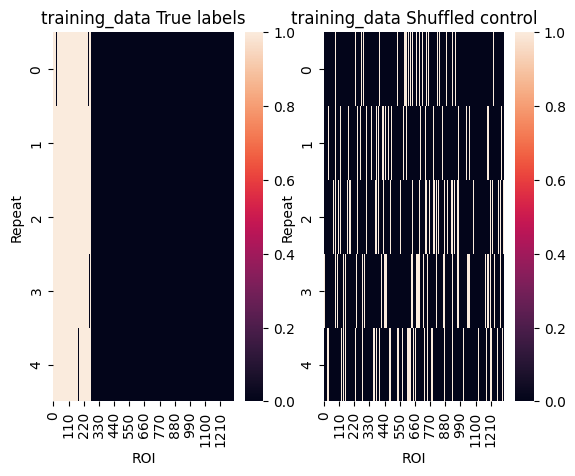

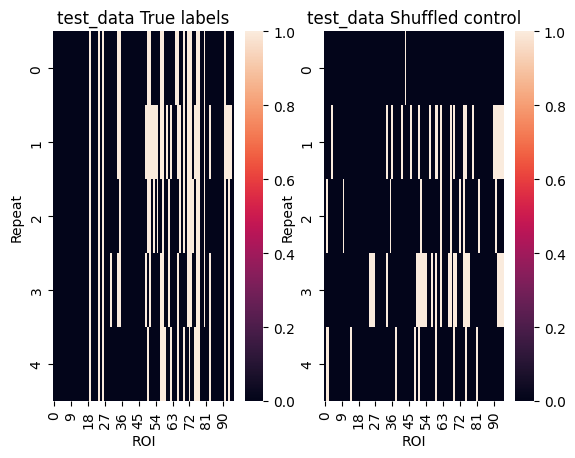

In [5]:
# Plot predictions as a heatmap (white = Active, black = Inactive)
for experiment in experiments:
    fig,axes=plt.subplots(1,2)
    for ax,pred,title in zip(axes,[pred_array,pred_array_shuf],['True labels','Shuffled control']):
        ax=sns.heatmap(pred[experiment],ax=ax);
        ax.set_xlabel('ROI');
        ax.set_ylabel('Repeat');
        ax.set_title(experiment + ' ' + title);

Histogram of fraction of times cells are classed as active
Probability density = bins raw count divided by the total number of counts and the bin width, so that the area under the histogram integrates to 1


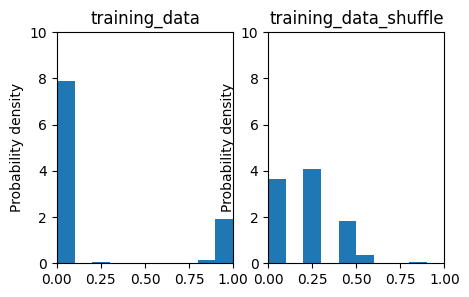

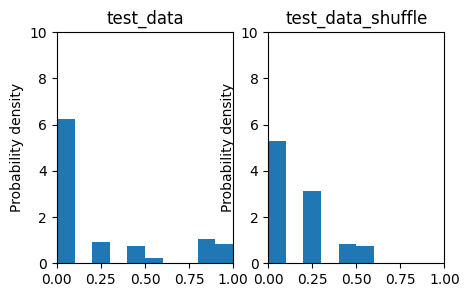

In [6]:
print('Histogram of fraction of times cells are classed as active')
print('Probability density = bins raw count divided by the total number of counts and the bin width, so that the area under the histogram integrates to 1')
all_counts =[]
all_bins =[]
last_bin =[]
for experiment in experiments:
    fig, axes = plt.subplots(1,2,figsize=(5,3))
    for ax,this_pred_array,title in zip(axes,[pred_array[experiment],pred_array_shuf[experiment]],[experiment, experiment+'_shuffle']):
        nloops = this_pred_array.shape[0]
        ax.set_title(title)
        hist_data = this_pred_array.sum(axis=0) / nloops
        ax.hist(hist_data, bins=10, range=(0, 1), density=True)  # Use density=True to plot proportion
        ax.set_xlim([0,1])
        ax.set_ylim([0,10])
        ax.set_ylabel('Probability density')
   # fig.savefig(os.path.join(output_folder_path,title+'_probability_density_'+str(nloops)+'loops.pdf'))
   # fig.savefig(os.path.join(output_folder_path,title+'_probability_density_'+str(nloops)+'loops.jpg'))

In [7]:
# Assess accuracy in training data
experiments_with_labels = np.array(experiments)[has_labels]
labels_binary ={}
for e in experiments_with_labels:
    labels_binary[e]=[1 if x else 0 for x in labels[e]=='active']
lidocaine_labels = labels_binary

[Accuracies,Precisions,Recalls,Specificities]=get_performance_measures(output_folder_path,pred_array, experiments_with_labels, lidocaine_labels, shuffle=False)
[Accuracies_shuf,Precisions_shuf,Recalls_shuf,Specificities_shuf]=get_performance_measures(output_folder_path,pred_array_shuf, experiments_with_labels, lidocaine_labels, shuffle=True)

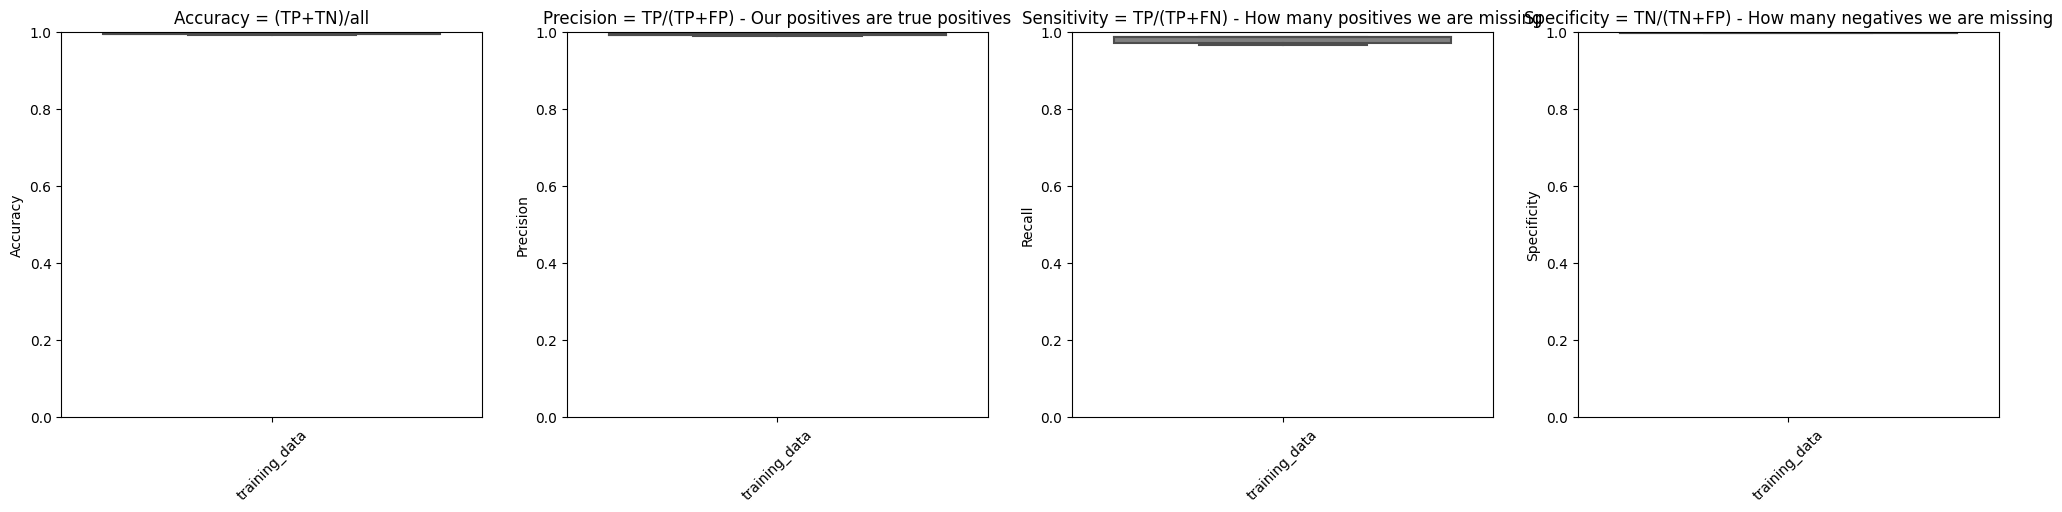

In [14]:
# Plot performance measures for models trained on data with true labels

fig, axes = plt.subplots(1,4, figsize =(25,5))
for ax, measure,label,title in zip(axes,[Accuracies,Precisions,Recalls,Specificities],['Accuracy','Precision','Recall', 'Specificity'], ['Accuracy = (TP+TN)/all', 'Precision = TP/(TP+FP) - Our positives are true positives', 'Sensitivity = TP/(TP+FN) - How many positives we are missing', 'Specificity = TN/(TN+FP) - How many negatives we are missing']):
    ax=sns.boxplot(data=pd.DataFrame(data=measure), ax=ax,color='Grey')
    ax.set_ylim([0,1])
    ax.set_title(title)
    ax.set_ylabel(label)
    ax.tick_params(axis='x', labelrotation=45)

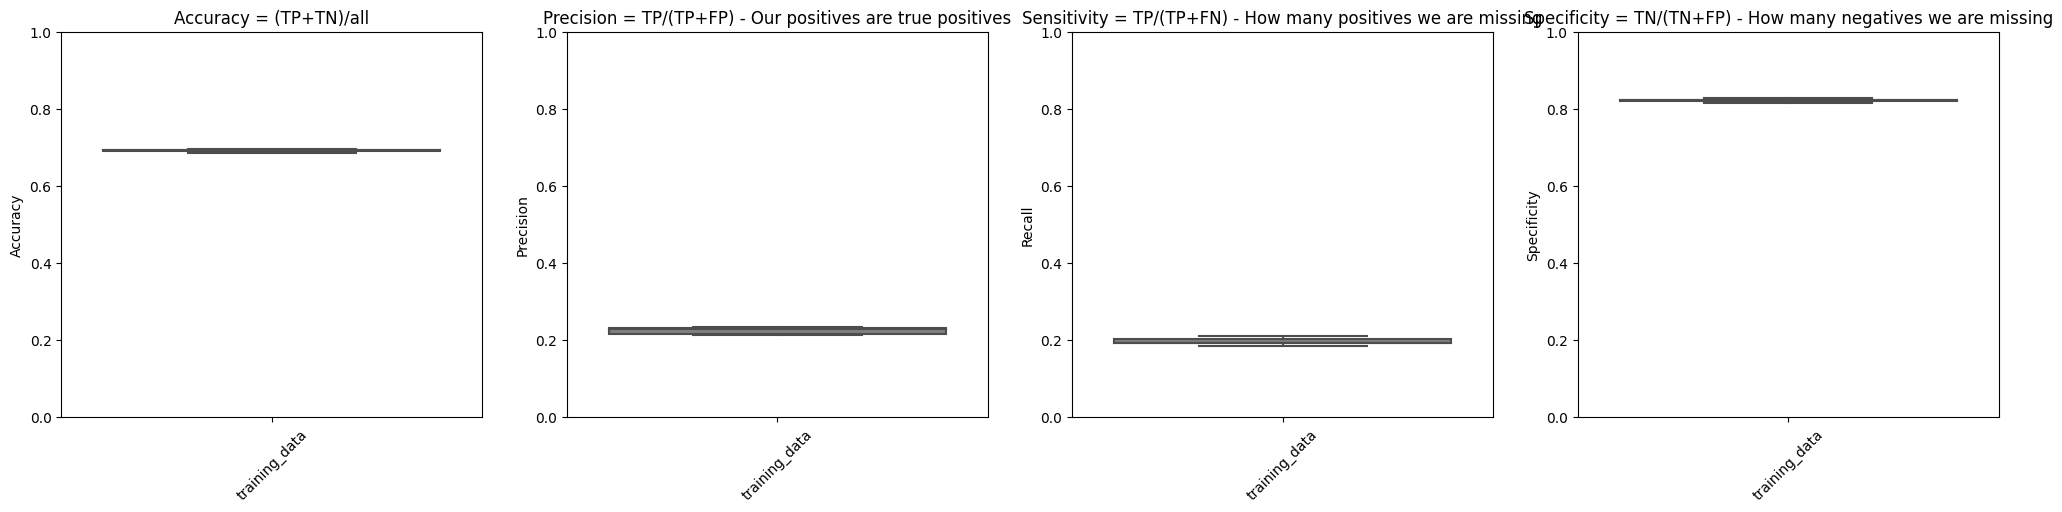

In [13]:
# Plot performance measures for models trained on data with shuffled labels

fig, axes = plt.subplots(1,4, figsize =(25,5))
for ax, measure,label,title in zip(axes,[Accuracies_shuf,Precisions_shuf,Recalls_shuf,Specificities_shuf],['Accuracy','Precision','Recall', 'Specificity'], ['Accuracy = (TP+TN)/all', 'Precision = TP/(TP+FP) - Our positives are true positives', 'Sensitivity = TP/(TP+FN) - How many positives we are missing', 'Specificity = TN/(TN+FP) - How many negatives we are missing']):
    ax=sns.boxplot(data=pd.DataFrame(data=measure), ax=ax,color='Grey')
    ax.set_ylim([0,1])
    ax.set_title(title)
    ax.set_ylabel(label)
    ax.tick_params(axis='x', labelrotation=45)